# The notebook contains
### Code for _Bulyan_ aggregation algorithm, *when gradient updates of benign clients are unknown to adversary*
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

## Import packages

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp
import math
sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD


## Data split
Divide cifar10 data among 50 clients in Non-IID fashion using Dirichlet distribution

Graph the distribution of classes for each user

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
data_loc='/mnt/nfs/work1/amir/vshejwalkar/cifar10_data/'
# load the train dataset

train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

cifar10_train = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=train_transform)

cifar10_test = datasets.CIFAR10(root=data_loc, train=False, download=True, transform=train_transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
total_tr_len = len(cifar10_train)

X={}
Y=[]
for i in range(len(cifar10_train)):
    data = cifar10_train[i][0].numpy()
    label = cifar10_train[i][1]

    if label in X:
        X[label].append(data)
    else:
        X[label] = []
        X[label].append(data)
        Y.append(label)

for label in X:
    X[label] = np.array(X[label])
Y=np.array(Y)

alpha = 1
n_users = 50

In [5]:
user_train_data_non_tensors = [[] for _ in range(n_users)]
user_train_label_non_tensors = [[] for _ in range(n_users)]

for label in Y:
    alpha_list = [alpha for _ in range(n_users)]
    probs = np.random.dirichlet(alpha_list)

    taken_index = 0

    for i, prob in enumerate(probs):
        if i == n_users - 1:
            user_train_data_non_tensors[i].extend(X[label][taken_index:])
            user_train_label_non_tensors[i].extend([label for _ in range(len(X[label]) - taken_index)])
        else:
            n_sample = math.floor(prob * len(X[label]))

            user_train_data_non_tensors[i].extend(X[label][taken_index : taken_index + n_sample])
            user_train_label_non_tensors[i].extend([label for _ in range(n_sample)])
            taken_index += n_sample

user_train_data_tensors = []
user_train_label_tensors = []

user_tr_len = []

for i in range(n_users):

    if len(user_train_data_non_tensors[i]) != len(user_train_label_non_tensors[i]):
        sys.exit(f"Shape does not match user_train_data_non_tensors[i] hsa {len(user_train_data_non_tensors[i])}, while user_train_label_non_tensors[i] has {len(user_train_label_non_tensors[i])}")


    num_data = len(user_train_data_non_tensors[i])
    user_tr_len.append(num_data)

    user_train_data_tensors.append(torch.from_numpy(np.array(user_train_data_non_tensors[i])).type(torch.FloatTensor))
    user_train_label_tensors.append(torch.from_numpy(np.array(user_train_label_non_tensors[i])).type(torch.LongTensor))

    r=np.arange(num_data)

    np.random.shuffle(r)

    user_train_data_tensors[i] = user_train_data_tensors[i][r]
    user_train_label_tensors[i] = user_train_label_tensors[i][r]

    print(f'user {i} has {user_train_data_tensors[i].shape[0]} train data, and {user_train_label_tensors[i].shape[0]} train labels')



user 0 has 951 train data, and 951 train labels
user 1 has 1268 train data, and 1268 train labels
user 2 has 799 train data, and 799 train labels
user 3 has 709 train data, and 709 train labels
user 4 has 463 train data, and 463 train labels
user 5 has 1218 train data, and 1218 train labels
user 6 has 1574 train data, and 1574 train labels
user 7 has 1279 train data, and 1279 train labels
user 8 has 1423 train data, and 1423 train labels
user 9 has 1281 train data, and 1281 train labels
user 10 has 1216 train data, and 1216 train labels
user 11 has 1062 train data, and 1062 train labels
user 12 has 1261 train data, and 1261 train labels
user 13 has 1147 train data, and 1147 train labels
user 14 has 902 train data, and 902 train labels
user 15 has 1011 train data, and 1011 train labels
user 16 has 620 train data, and 620 train labels
user 17 has 662 train data, and 662 train labels
user 18 has 629 train data, and 629 train labels
user 19 has 1101 train data, and 1101 train labels
user 2

In [6]:
X2 = []
Y2 = []

for i in range(len(cifar10_test)):
    X2.append(cifar10_test[i][0].numpy())
    Y2.append(cifar10_test[i][1])

X2=np.array(X2)
Y2=np.array(Y2)

half_index = len(X2) // 2

val_data= X2[:half_index]
val_label= Y2[:half_index]

te_data=X2[half_index:]
te_label=Y2[half_index:]

val_data_tensor=torch.from_numpy(val_data).type(torch.FloatTensor)
val_label_tensor=torch.from_numpy(val_label).type(torch.LongTensor)

te_data_tensor=torch.from_numpy(te_data).type(torch.FloatTensor)
te_label_tensor=torch.from_numpy(te_label).type(torch.LongTensor)

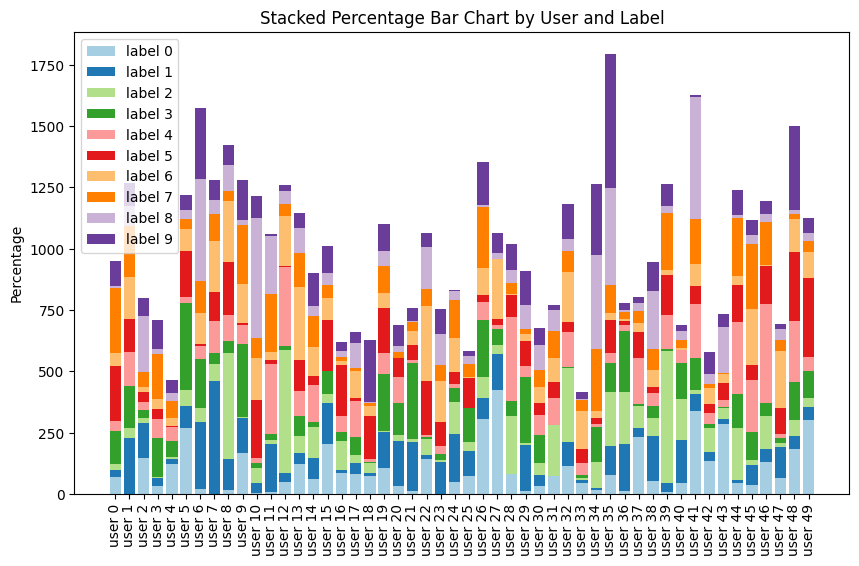

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Example data
users = [f"user {i}" for i in range(50)]
labels = [f"label {i}" for i in range(10)]


percentages = []
for user_data in user_train_label_non_tensors:
    temp_holder = []
    for label in range(10):
        temp_holder.append(user_data.count(label))
    percentages.append(temp_holder)

percentages = np.array(percentages)

# Assuming 'percentages' is populated correctly as shown previously
# Convert percentages to cumulative sum for stacking
cumulative = np.cumsum(percentages, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each ethnicity, ensuring there are enough colors for all labels
colors = plt.cm.Paired(range(len(labels))) # Repeating colors to match the number of labels

# Create stacked bars
for i in range(len(labels)):  # Iterate over the number of labels
    if i == 0:
        ax.bar(users, percentages[:, i], color=colors[i], label=labels[i])
    else:
        ax.bar(users, percentages[:, i], bottom=cumulative[:, i-1], color=colors[i], label=labels[i])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Stacked Percentage Bar Chart by User and Label')
ax.set_xticks(np.arange(len(users)))
ax.set_xticklabels(users, rotation=90)  # Rotate labels if needed
ax.legend()


plt.savefig('./non_iid_user_label_distribution.png', bbox_inches='tight')
plt.show()


## Our Aggregation Function

In [8]:
def our_mean_defense(all_updates, n_attackers, history_updates):
    discarded_history = get_discarded_index(n_attackers, history_updates)

    mask = torch.ones(all_updates.size(0), dtype=torch.bool)
    mask[discarded_history] = False
    remaining_updates = all_updates[mask]

    print('discarded index', discarded_history)

    return torch.nanmean(remaining_updates, dim=0)

####
def euclidean_distance(row1, row2):
    return torch.sqrt(torch.sum((row1 - row2) ** 2))
####

def get_discarded_index(n_attackers, history_updates):
    n_users = history_updates.shape[0]

    ####
    distance_matrix = [[0 if i == j else euclidean_distance(history_updates[i, :], history_updates[j, :]) for j in range(n_users)] for i in range(n_users)]
    ####

    sum_of_distances = [sum(row) for row in distance_matrix]

    discarded_history = []
    for _ in range(n_attackers):
        max_distance = max(sum_of_distances)
        index_of_max_distance = sum_of_distances.index(max_distance)
        discarded_history.append(index_of_max_distance)

        for i in range(n_users):
            sum_of_distances[i] -= distance_matrix[i][index_of_max_distance]
        sum_of_distances[index_of_max_distance] = -1

    return discarded_history


## Code for no defense aggregation algorithm

In [9]:
def no_defense_aggregation(user_grads):
    return torch.nanmean(user_grads, dim=0)

## our_attack_mean
$ argmin_\theta(\ -L(\theta_{attacker(s)}) + \lambda_1 |\bar{\theta_{abs\ mean\ benige\ users}} - \bar{\theta_{abs\ attacker(s)}}|$

In [10]:
device = 'cuda:0'
def check_condition(lambda1, prev_grad, loss_grad, history, all_updates, n_users, n_attacker, epoch_num):
    loss_grad = loss_grad.to(device)
    prev_grad = prev_grad.to(device)
    new_grad = lambda1 * (loss_grad + prev_grad)
    
    ####
    mal_updates = torch.stack([new_grad.clone().detach() for _ in range(n_attacker)])
    malicious_grads = torch.cat((mal_updates, all_updates[n_attacker:]), 0)

    history_updates = history.clone().detach()
    history_updates[:, epoch_num] = malicious_grads.abs().mean(dim=1, keepdim=True).squeeze()
    ####

    discarded_history = get_discarded_index(n_attacker, history_updates)

    detected_mal = len([item for item in discarded_history if item < 10])
    return detected_mal / len(discarded_history) <= n_attacker / n_users

def find_upper_bound(lambda1, prev_grad, loss_grad, history, all_updates, n_users, n_attacker, epoch_num):
    while check_condition(lambda1, prev_grad, loss_grad, history, all_updates, n_users, n_attacker, epoch_num):
        lambda1 *= 2  # Exponentially increase lambda
    return lambda1


def projection(prev_grad, loss_grad, history, all_updates, n_users, n_attacker, epoch_num):
    updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)

    ####
    history_updates = history.clone().detach()
    history_updates[:, epoch_num] = updates_abs_mean.mean(dim=1, keepdim=True).squeeze()
    ####

    lambda_low = 0
    lambda_high = find_upper_bound(1, prev_grad, loss_grad, history_updates, all_updates, n_users, n_attacker, epoch_num)
    tolerance = 1e-4

    while lambda_high - lambda_low > tolerance:
        lambda_mid = (lambda_low + lambda_high) / 2
        if check_condition(lambda_mid, prev_grad, loss_grad, history_updates, all_updates, n_users, n_attacker, epoch_num):
            lambda_low = lambda_mid
        else:
            lambda_high = lambda_mid

    lambda1 = lambda_low

    loss_grad = loss_grad.to(device)
    prev_grad = prev_grad.to(device)
    return lambda1 * (prev_grad + loss_grad)

def our_attack_mean(n_user, epoch_num, history_updates, all_updates, model_params, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors):
    attacker_tr_data_tensor = user_train_data_tensors[0].cuda()
    attacker_tr_label_tensor = user_train_label_tensors[0].cuda()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    fed_model.eval()  # Ensure the model is in evaluation mode

    new_grad = -all_updates[0].clone().detach().requires_grad_(True)
    prev_grad = np.zeros(len(new_grad))
    new_grad = projection(torch.from_numpy(prev_grad), new_grad, history_updates, all_updates, n_user, n_attacker, epoch_num)

    while True:
        outputs = fed_model(attacker_tr_data_tensor)
        loss = criterion(outputs, attacker_tr_label_tensor)

        loss.backward(retain_graph=True)
        param_grad = []
        for param in fed_model.parameters():
            param_grad.append(param.grad.view(-1).detach())

        param_grad = torch.cat(param_grad)
        prev_grad = new_grad
        new_grad = projection(prev_grad, param_grad, history_updates, all_updates, n_user, n_attacker, epoch_num)

        difference = torch.mean(torch.abs(new_grad - prev_grad)).item()
        if difference < 1e-6:
            # print("STOPPED! Difference is too small, stop finding best attack grad")
            break

        fed_model.zero_grad()

    result_attacker_grads = [new_grad.clone().detach() for _ in range(10)]
    return torch.stack(result_attacker_grads).cuda()


## Set number of epochs

In [13]:
nepochs= 300

## no defense

In [14]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    ####
    history = torch.zeros((n_users, nepochs + 1), dtype=torch.float32).cuda()
    ####
    
    model_grads = []
    flag = False
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))


            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        updates_abs_mean = user_grads.abs().mean(dim=1, keepdim=True)

        if n_attacker > 0:
            model_params = torch.cat([p.data.view(-1) for p in fed_model.parameters()])
            mal_updates = our_attack_mean(n_users, epoch_num, history, user_grads, model_params, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:   # No attack
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)

        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)

        history[:, epoch_num] = updates_abs_mean.squeeze()
        agg_grads = no_defense_aggregation(malicious_grads)
        # agg_grads = our_mean_defense(malicious_grads, n_attacker, history)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./our attack + 10 attacker + our defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

epoch: 0, bulyan: at our-agr n_at 10 e 0 | val loss 2.3030 val acc 11.8912 best val_acc 11.891234


C:\Users\Hizan\AppData\Local\Temp\ipykernel_8848\3641091555.py:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 1, bulyan: at our-agr n_at 10 e 1 | val loss 2.3028 val acc 9.8011 best val_acc 11.891234
epoch: 2, bulyan: at our-agr n_at 10 e 2 | val loss 2.3028 val acc 10.0244 best val_acc 11.891234
epoch: 3, bulyan: at our-agr n_at 10 e 3 | val loss 2.3029 val acc 9.6997 best val_acc 11.891234
epoch: 4, bulyan: at our-agr n_at 10 e 4 | val loss 2.3031 val acc 9.6997 best val_acc 11.891234
epoch: 5, bulyan: at our-agr n_at 10 e 5 | val loss 2.3034 val acc 9.6997 best val_acc 11.891234
epoch: 6, bulyan: at our-agr n_at 10 e 6 | val loss 2.3040 val acc 9.6997 best val_acc 11.891234
epoch: 7, bulyan: at our-agr n_at 10 e 7 | val loss 2.3046 val acc 9.6997 best val_acc 11.891234
epoch: 8, bulyan: at our-agr n_at 10 e 8 | val loss 2.3036 val acc 9.6997 best val_acc 11.891234
epoch: 9, bulyan: at our-agr n_at 10 e 9 | val loss 2.3026 val acc 9.6997 best val_acc 11.891234
epoch: 10, bulyan: at our-agr n_at 10 e 10 | val loss 2.3017 val acc 9.6997 best val_acc 11.891234
epoch: 11, bulyan: at our-a

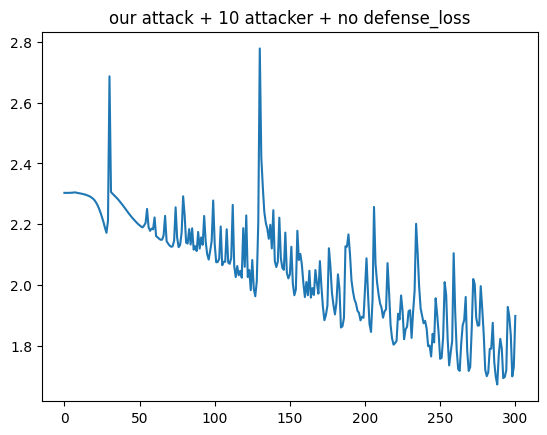

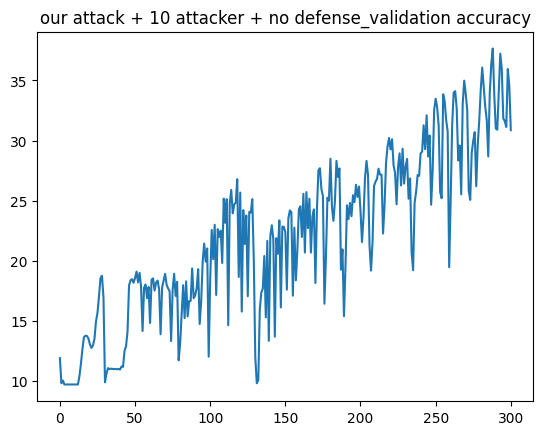

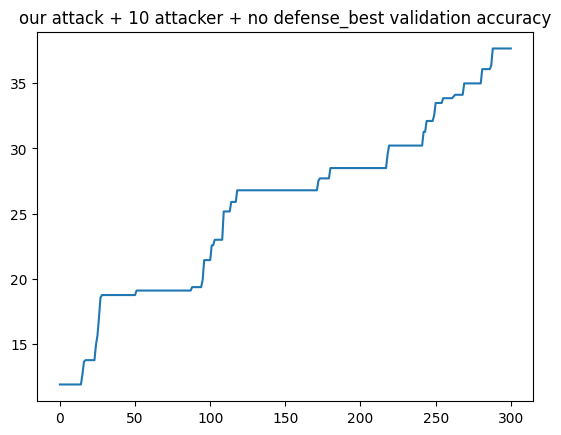

In [15]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + no defense_"+col)
    plt.savefig('./our attack + 10 attacker + no defense ' + col + '.png')
    plt.show()

## No Attack

In [16]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[0]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    ####
    history = torch.zeros((n_users, nepochs + 1), dtype=torch.float32).cuda()
    ####
    
    model_grads = []
    flag = False
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))


            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        updates_abs_mean = user_grads.abs().mean(dim=1, keepdim=True)

        if n_attacker > 0:
            model_params = torch.cat([p.data.view(-1) for p in fed_model.parameters()])
            mal_updates = our_attack_mean(n_users, epoch_num, history, user_grads, model_params, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:   # No attack
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)

        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)

        history[:, epoch_num] = updates_abs_mean.squeeze()
        # agg_grads = no_defense_aggregation(malicious_grads)
        agg_grads = our_mean_defense(malicious_grads, n_attacker, history)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./our attack + 10 attacker + our defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

discarded index []
epoch: 0, bulyan: at our-agr n_at 0 e 0 | val loss 2.3026 val acc 13.3726 best val_acc 13.372565


C:\Users\Hizan\AppData\Local\Temp\ipykernel_8848\923129905.py:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


discarded index []
epoch: 1, bulyan: at our-agr n_at 0 e 1 | val loss 2.3021 val acc 15.2192 best val_acc 15.219156
discarded index []
epoch: 2, bulyan: at our-agr n_at 0 e 2 | val loss 2.3015 val acc 12.6623 best val_acc 15.219156
discarded index []
epoch: 3, bulyan: at our-agr n_at 0 e 3 | val loss 2.3009 val acc 14.3466 best val_acc 15.219156
discarded index []
epoch: 4, bulyan: at our-agr n_at 0 e 4 | val loss 2.3002 val acc 13.9407 best val_acc 15.219156
discarded index []
epoch: 5, bulyan: at our-agr n_at 0 e 5 | val loss 2.2994 val acc 14.0625 best val_acc 15.219156
discarded index []
epoch: 6, bulyan: at our-agr n_at 0 e 6 | val loss 2.2985 val acc 14.7524 best val_acc 15.219156
discarded index []
epoch: 7, bulyan: at our-agr n_at 0 e 7 | val loss 2.2974 val acc 15.5438 best val_acc 15.543831
discarded index []
epoch: 8, bulyan: at our-agr n_at 0 e 8 | val loss 2.2962 val acc 15.3815 best val_acc 15.543831
discarded index []
epoch: 9, bulyan: at our-agr n_at 0 e 9 | val loss 2.

## Execute our attack + 10 attacker + our defense

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

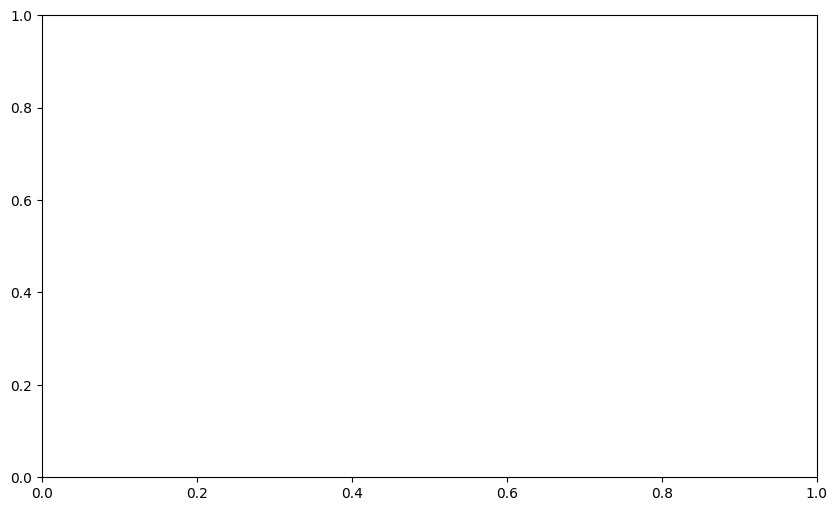

In [18]:
import matplotlib.pyplot as plt
import numpy as np

ne =  301

for j in range(10):
  plt.figure(figsize=(10, 6))
  x = np.arange(ne)
  for i in range(40):
      y = history[i+10]
      plt.plot(x, y, color='green')

  # for i in range(10):
  #     y = history[i]
  #     plt.plot(x, y, color='red')
  y = history[j]
  plt.plot(x, y, color='red')


  plt.title('history')
  plt.xlabel('epoch')
  plt.ylabel('mean')
  plt.legend()
  plt.grid(True)
  plt.savefig('./history_malicious_'+str(j)+'.png')
  plt.show()

In [ ]:
ne = 304

plt.figure(figsize=(10, 6))
x = np.arange(ne)
for i in range(40):
    y = history[i+10]
    plt.plot(x, y, color='green')

for i in range(10):
    y = history[i]
    plt.plot(x, y, color='red')

plt.title('history')
plt.xlabel('epoch')
plt.ylabel('mean')
plt.legend()
plt.grid(True)
plt.show()

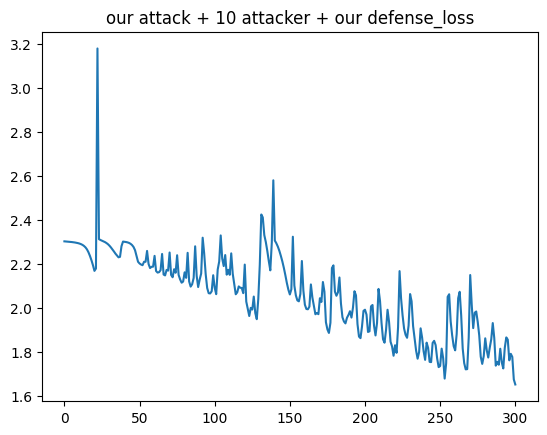

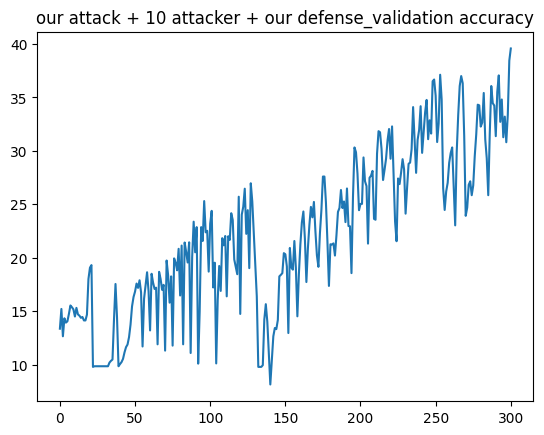

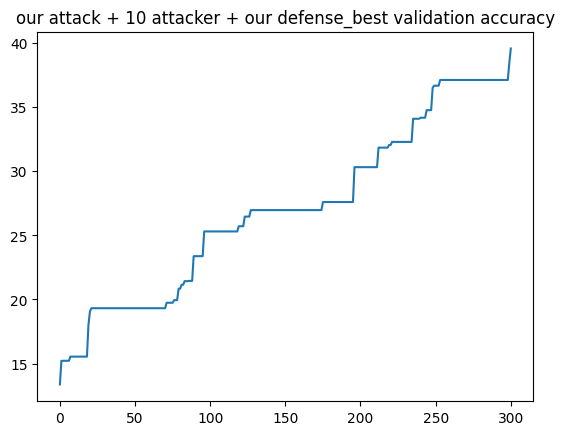

In [19]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + our defense_"+col)
    plt.savefig('./our attack + 10 attacker + our defense ' + col + '.png')
    plt.show()